# Anime Recommendation System

# Contents <a id='back'></a>

* [1. Introduction](#intro)
    * [1.1 Objective](#objective)
* [2. Initialisation](#init)
* [3. Data Exploration and Data Preprocessing](#data_exploration)
* [4. Exploratory Data Analysis (EDA)](#eda)
    * [4.1 Number of Animes Released](#animes_released)
    * [4.2 Top Genres](#genres)
    * [4.3 Top Animes](#animes)
* [5. Collaborative Filtering Recommendation System](#collaborative)
    * [5.1 Data Preparation](#col_data)
    * [5.2 Modeling](#col_model)
    * [5.3 Recommend the Existing Animes with the Highest Predicted Ratings to an Existing User](#col_1)
    * [5.4 Recommend an Existing Anime to the Existing Users who Have the Highest Predicted Ratings](#col_2)
    * [5.5 Recommend the Existing Animes which are Most Similar to the Highest Rated Animes by an Existing User (Item Based Recommendation)](#col_3)
    * [5.6 Recommend the Exisitng Highest Rated Animes by the Most Similar Users to an Existing User (User Based Recommendation)](#col_4)
* [6. Content-Based Filtering Recommendation System](#content)
    * [6.1 Data Preparation](#con_data)
    * [6.2 Modeling](#con_model)
    * [6.3 New Anime and New User](#new)
    * [6.4 Existing Anime and User Contents](#existing)
    * [6.5 Recommend the Existing Animes with the Highest Predicted Rating to a New User](#con_1)
    * [6.6 Recommend a New Anime to the Existing Users who Have the Highest Precticted Ratings](#con_2)
    * [6.7 Recommend a New Anime to the Existing Users who Have the Highest Ratings on Similar Animes (Item Based Recommendation)](#con_3)
    * [6.8 Recommend the Exisitng Highest Rated Animes by the Most Similar Users to a New User (User Based Recommendation)](#con_4)
* [7. References](#ref)

## 1. Introduction <a id='intro'></a>

A recommendation system is a powerful tool designed to analyse user data and preferences to generate personalised suggestions, thereby enhancing user experience and facilitating decision-making process. Recommedation systems play a crucial role in various domain such as e-commerce, streaming services, and content platforms, by helping users discover relevant products, movies, music, or information amidst the overwheming abundance of availabel choices. These systems not only increase user engagement and satisfaction but also drive revenue growth and forter customer loyalty by delivering tailored content.

### 1.1 Objective <a id='objective'></a>

This project aims to develop an anime recommendation system for anime fans.

[Back to Contents](#back)

## 2. Initialisation <a id='init'></a>

In [1]:
# Data manipulation and processing
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Flatten, Dropout, Lambda
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

[Back to Contents](#back)

## 3. Data Exploration and Data Preprocessing <a id='data_exploration'></a>

The datasets used in this project are available at [Kaggle](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020).

**Anime Dataset**

In [2]:
# Load the datasets with necessary columns
columns_to_load = ['MAL_ID', 'Name', 'Score', 'Genres', 'Aired', 'Producers', 'Licensors', 'Studios', 'Source']
df_anime = pd.read_csv('anime_1/anime.csv', usecols=columns_to_load)

columns_to_load = ['MAL_ID', 'sypnopsis']
df_anime_syp = pd.read_csv('anime_1/anime_with_synopsis.csv', usecols=columns_to_load)

In [3]:
# Have a look at the first three rows
display(df_anime.head(3))
display(df_anime_syp.head(3))

,MAL_ID,Name,Score,Genres,Aired,Producers,Licensors,Studios,Source
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","Apr 3, 1998 to Apr 24, 1999",Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","Sep 1, 2001","Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Apr 1, 1998 to Sep 30, 1998",Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga


,MAL_ID,sypnopsis
0,1,"In the year 2071, humanity has colonized sever..."
1,5,"other day, another bounty—such is the life of ..."
2,6,"Vash the Stampede is the man with a $$60,000,0..."


In [4]:
# Merge the two datasets
df_anime = df_anime.merge(df_anime_syp, on='MAL_ID', how='inner')

In [5]:
# Have a look at the merged dataset
df_anime.head(3)

,MAL_ID,Name,Score,Genres,Aired,Producers,Licensors,Studios,Source,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","Apr 3, 1998 to Apr 24, 1999",Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","Sep 1, 2001","Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Apr 1, 1998 to Sep 30, 1998",Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,"Vash the Stampede is the man with a $$60,000,0..."


In [6]:
# Check the shape
df_anime.shape

(16214, 10)

The dataset contains 16214 rows (anime) with 10 columns of relevant information for each anime.

**Description of data**

- `MAL_ID`: A unique identifier for an anime.
- `Name`: The name of the anime.
- `Score`: The average score rated by users.
- `Genres`: The genres which an anime belongs to.
- `Aired`: The airing schedule of the anime.
- `Producers`: The name of the production company.
- `Licensors`: The name of the company that hold the licensing rights for an anime.
- `Studios`: The name of studio which is responsible for producint the anime.
- `Source`: The source material (e.g. manga, game, and etc.) from which an anime is adapted.
- `Synopsis`: An overview of the plot, characters, themes, and setting of an anime.

In [7]:
# Rename the column names
df_anime.columns = [x.lower() for x in df_anime.columns]
df_anime.rename(columns={'mal_id': 'anime_id', 'name': 'anime'}, inplace=True)

df_anime.sample()

,anime_id,anime,score,genres,aired,producers,licensors,studios,source,sypnopsis
12027,35673,Yama no Susume: Omoide Present,7.38,"Adventure, Comedy, Slice of Life","Oct 28, 2017",Yomiuri TV Enterprise,Unknown,8bit,Manga,"On the final day of summer vacation, Kokona Ao..."


In [8]:
# Check for duplicates
df_anime.duplicated().sum()

0

In [9]:
# Check for missing values
df_anime.isna().sum()

anime_id     0
anime        0
score        0
genres       0
aired        0
producers    0
licensors    0
studios      0
source       0
sypnopsis    8
dtype: int64

There are 8 missing values in `sypnopsis` but it wont affect our recommendation system will not be based on this feature.

In [10]:
# Check the descriptive statistics
df_anime.describe(include='all')

,anime_id,anime,score,genres,aired,producers,licensors,studios,source,sypnopsis
count,16214.000000,16214,16214,16214,16214,16214,16214,16214,16214,16206
unique,NaN,16210,532,4857,10888,3595,216,1038,16,15221
top,NaN,Maou Gakuin no Futekigousha: Shijou Saikyou no...,Unknown,Music,Unknown,Unknown,Unknown,Unknown,Original,No synopsis information has been added to this...
freq,NaN,3,5123,790,308,7458,12467,6165,5086,709
mean,22069.271555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14849.798248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,6728.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,24164.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,35978.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will only use the animes which were released after 2015 to build the recommendation system, therefore the rows with `Unknown` in `aired` will be dropped. In addition, the rows with `Unknown` in `score` will also be dropped.

In [11]:
# Drop the rows with `unknown` values
df_anime = df_anime[df_anime['score'] != 'Unknown']
df_anime = df_anime[df_anime['aired'] != 'Unknown']

A function will be created to extract the year of premiered.

In [12]:
# Create the year of premiered
def create_premiered(aired):
    if len(aired) == 4:
        year = aired
    elif 'to' in aired:
        if len(aired) > 12:
            year = aired.split(',')[1].strip()[:4]                
        else:
            year = aired[:4]
    else:
        year = aired.split(',')[1].strip()

    return year


df_anime['premiered'] = df_anime['aired'].apply(create_premiered)

In [13]:
# Have a look the they year of premiered
df_anime[['aired', 'premiered']].head()

,aired,premiered
0,"Apr 3, 1998 to Apr 24, 1999",1998
1,"Sep 1, 2001",2001
2,"Apr 1, 1998 to Sep 30, 1998",1998
3,"Jul 2, 2002 to Dec 24, 2002",2002
4,"Sep 30, 2004 to Sep 29, 2005",2004


In [14]:
# Check if any anime without year of premiered
df_anime['premiered'].isna().sum()

0

In [15]:
# Check the data types
df_anime.dtypes

anime_id      int64
anime        object
score        object
genres       object
aired        object
producers    object
licensors    object
studios      object
source       object
sypnopsis    object
premiered    object
dtype: object

In [16]:
# Correct the data types
df_anime['score'] = df_anime['score'].astype(float)
df_anime['premiered'] = df_anime['premiered'].astype(int)

In [17]:
# Animes after 2015
df_anime_1 = df_anime.query('premiered >= 2015').reset_index(drop=True)

In [18]:
# Find the total number of animes which were released after 2015
print(f'Total anime released after 2015 in the dataset: {df_anime_1.shape[0]}')

Total anime released after 2015 in the dataset: 3280


**User Rating Dataset**

In [19]:
# Load the dataset
df_rating = pd.read_csv('anime_1/rating_complete.csv')

In [20]:
# Have a look at the first five rows
df_rating.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [21]:
# Check the shape
df_rating.shape

(57633278, 3)

There are 57633279 rows (ratings from users) with 3 columns of relevant information for each rating.

**Description of data**

- `user_id`: A unique identifier for a user.
- `anime_id`: A unique identifier for an anime.
- `rating`: The rating given to the anime by the user.

In [22]:
# Get the ratings of animes after 2015
df_rating = df_rating.merge(df_anime_1[['anime_id', 'anime', 'genres']], on='anime_id', how='right')

We will only use the data from the hardcore anime fans who gave at least 500 ratings.

In [23]:
# Find the users who gave at least 500 ratings
rating_count = df_rating.groupby('user_id').size()
save_user_id = rating_count[rating_count >= 500].index
df_rating_1 = df_rating[df_rating['user_id'].isin(save_user_id)]
df_rating_1 = df_rating_1.sort_values('user_id').reset_index(drop=True)

In [24]:
# Check how many users and ratings are left
print(f'Total users in the dataset: {df_rating_1["user_id"].nunique()}')
print(f'Total ratings given by users: {df_rating_1.shape[0]}')

Total users in the dataset: 1797
Total ratings given by users: 1256024


In [25]:
# Check for duplicates
df_rating_1.duplicated().sum()

0

In [26]:
# Check for missing values
df_rating_1.isna().sum()

user_id     0
anime_id    0
rating      0
anime       0
genres      0
dtype: int64

In [27]:
# Check the data types
df_rating_1.dtypes

user_id     float64
anime_id      int64
rating      float64
anime        object
genres       object
dtype: object

In [28]:
# Correct the data types for user_id
df_rating_1['user_id'] = df_rating_1['user_id'].astype(int)

[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

### 4.1 Number of Animes Released <a id='animes_released'></a>

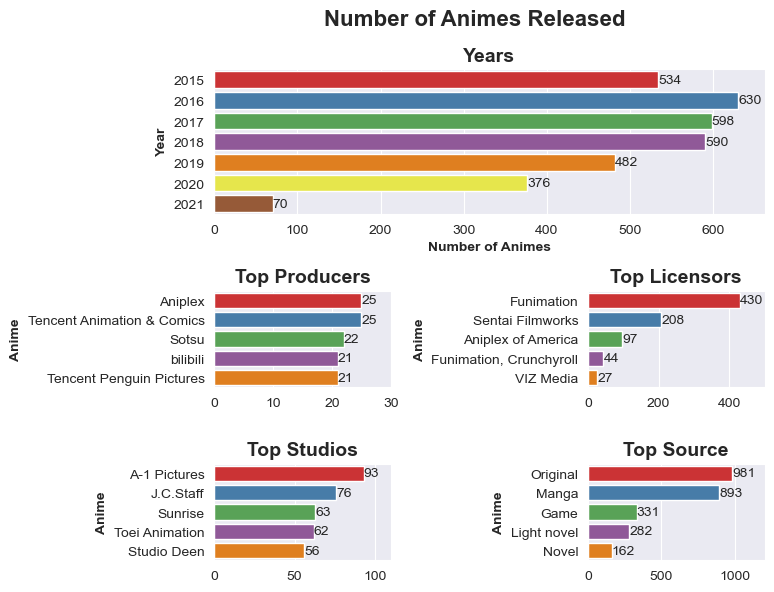

In [29]:
# Plot the bar charts
sns.set_style('darkgrid')
palette = 'Set1'

layout = '''
    aa
    bc
    de
'''

fig, axd = plt.subplot_mosaic(layout, height_ratios=[1.5, 1, 1], figsize=(8, 6))

fig.suptitle('Number of Animes Released', x=0.6, fontsize=16, fontweight='bold')

# By years
ax = axd['a']
sns.countplot(data=df_anime_1, y='premiered', hue='premiered', palette=palette, legend=False, ax=ax)
ax.set_title('Years', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Animes', fontweight='bold')
ax.set_ylabel('Year', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)

# By producers
df_t = df_anime_1.groupby('producers')['anime'].count().drop('Unknown').sort_values(ascending=False).head()

ax = axd['b']
sns.barplot(y=df_t.index, x=df_t.values, hue=df_t.index, palette=palette, ax=ax)
ax.set_title('Top Producers', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Anime', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 30)

# By licensors
df_t = df_anime_1.groupby('licensors')['anime'].count().drop('Unknown').sort_values(ascending=False).head()

ax = axd['c']
sns.barplot(y=df_t.index, x=df_t.values, hue=df_t.index, palette=palette, ax=ax)
ax.set_title('Top Licensors', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Anime', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 500)

# By studios
df_t = df_anime_1.groupby('studios')['anime'].count().drop('Unknown').sort_values(ascending=False).head()

ax = axd['d']
sns.barplot(y=df_t.index, x=df_t.values, hue=df_t.index, palette=palette, ax=ax)
ax.set_title('Top Studios', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Anime', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 110)

# By source
df_t = df_anime_1.groupby('source')['anime'].count().drop('Unknown').sort_values(ascending=False).head()

ax = axd['e']
sns.barplot(y=df_t.index, x=df_t.values, hue=df_t.index, palette=palette, ax=ax)
ax.set_title('Top Source', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Anime', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 1200)

plt.tight_layout()
plt.show()

Between the year of 2015 and 2021, the top three year with the highest number of animes released are 2016, 2017 and 2018.

`Aniplex`, `Funimation` and `A-1 Pictures` are the top producer, licensor and studio respectively. Most of the animes are original created or from Manga.

[Back to Contents](#back)

### 4.2 Top Genres <a id='genres'></a>

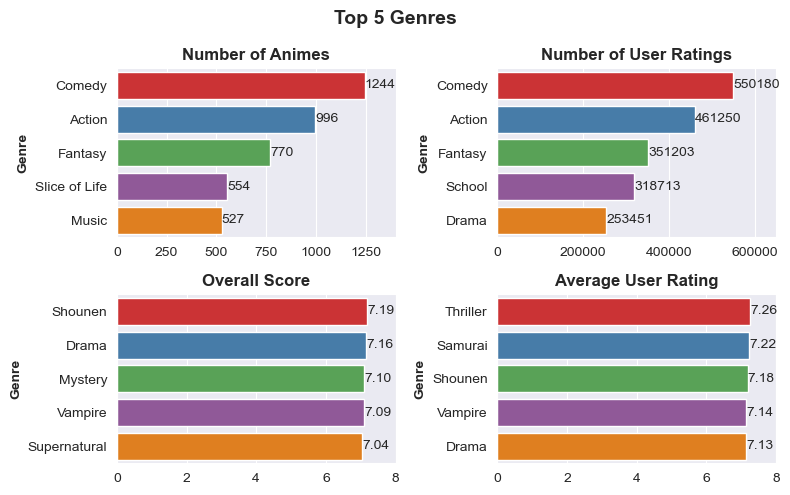

In [30]:
# Plot the bar charts
sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

fig.suptitle('Top 5 Genres', fontsize=14, fontweight='bold')
palette = 'Set1'

# Prepare the data for plotting
df_t = df_anime_1[['anime', 'genres', 'score']].copy()
df_t['genres'] = df_t['genres'].str.split(', ')
df_t = df_t.explode('genres').pivot_table(
    index = 'genres',
    values = ['anime', 'score'],
    aggfunc = {'anime': 'count',
                'score': 'mean'}
)

# Number of animes per genre
ax = axs[0][0]
sns.barplot(data=df_t.sort_values('anime', ascending=False).head(5),
            y='genres', x='anime', hue='genres', palette=palette, ax=ax)
ax.set_title('Number of Animes', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Genre', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 1400)

# Overall score per genre
ax = axs[1][0]
sns.barplot(data=df_t.sort_values('score', ascending=False).head(5),
            y='genres', x='score', hue='genres', palette=palette, ax=ax)
ax.set_title('Overall Score', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Genre', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
ax.set_xlim(0, 8)

# Prepare the data for plotting
df_t = df_rating_1[['anime', 'genres', 'rating']].copy()
df_t['genres'] = df_t['genres'].str.split(', ')
df_t = df_t.explode('genres').pivot_table(
    index = 'genres',
    values = ['anime', 'rating'],
    aggfunc = {'anime': 'count',
                'rating': 'mean'}
)

# Number of user ratings per genre
ax = axs[0][1]
sns.barplot(data=df_t.sort_values('anime', ascending=False).head(5),
            y='genres', x='anime', palette=palette, hue='genres', ax=ax)
ax.set_title('Number of User Ratings', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Genre', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 650000)

# Average user rating per genre
ax = axs[1][1]
sns.barplot(data=df_t.sort_values('rating', ascending=False).head(5),
            y='genres', x='rating', palette=palette, hue='genres', ax=ax)
ax.set_title('Average User Rating', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Genre', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
ax.set_xlim(0, 8)

plt.tight_layout()
plt.show()

The genres of `comedy`, `action` and `fantasy` have the most counts of animes and user ratings. The `drama` and `vampire` genres are the common genres in the top five overall scores and user ratings.

[Back to Contents](#back)

### 4.3 Top Animes <a id='animes'></a>

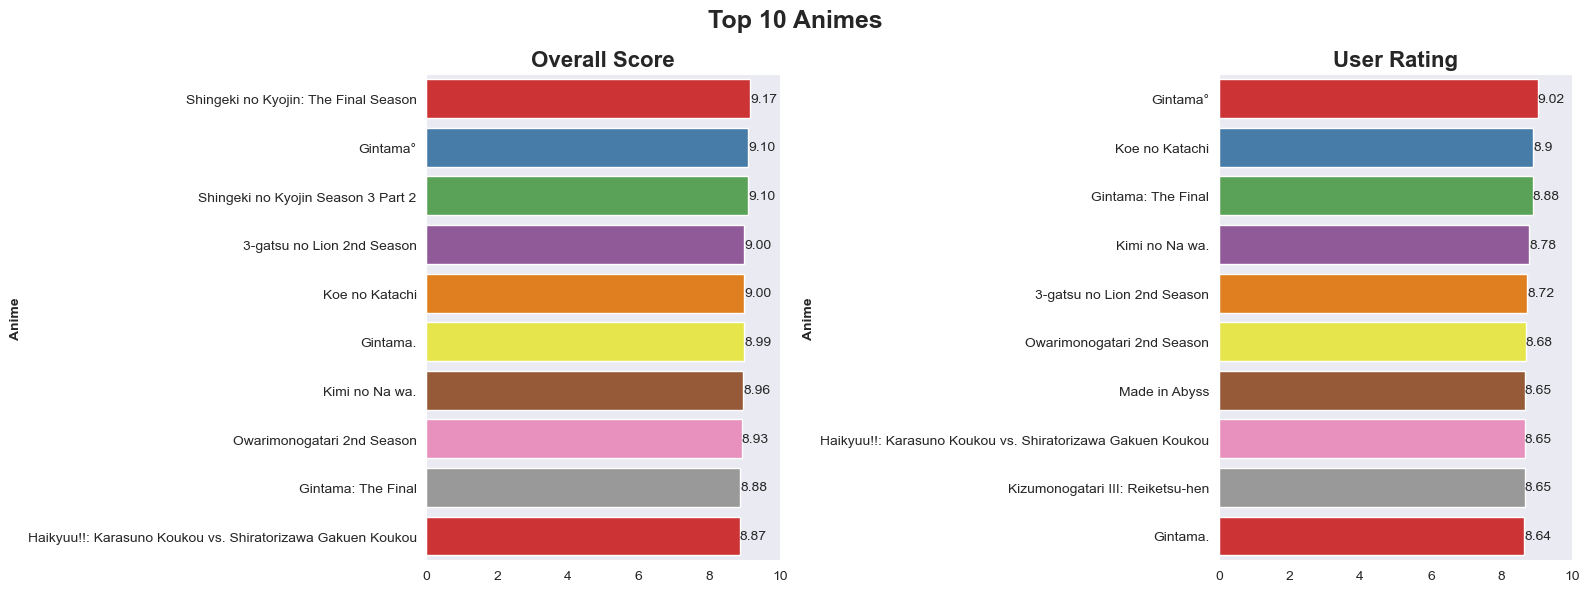

In [31]:
# Plot the bar charts
sns.set_style('dark')
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Top 10 Animes', fontsize=18, fontweight='bold')
palette = 'Set1'

# Overall score
df_t = df_anime_1.groupby('anime')['score'].mean().sort_values(ascending=False).head(10)

ax = axs[0]
sns.barplot(y=df_t.index, x=df_t.values, hue=df_t.index, palette=palette, ax=ax)
ax.set_title('Overall Score', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Anime', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
ax.set_xlim(0, 10)

# User rating
df_t = df_rating_1.groupby('anime')['rating'].mean().sort_values(ascending=False).head(10).round(2)

ax = axs[1]
sns.barplot(y=df_t.index, x=df_t.values, hue=df_t.index, palette=palette, ax=ax)
ax.set_title('User Rating', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Anime', fontweight='bold')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlim(0, 10)

plt.tight_layout()
plt.show()

The animes in the top 10 lists of overall score and user rating are almost the same except `Shingeki no Kyojin: The Final Season`, `Shingeki no Kyojin Season 3 Part 2`, `Kimi no Na wa` and `Kizumonogatari III: Reiketsu-hen`. It is interesting to see that `Shingeki no Kyojin` is not so high-rated among these hardcore anime fans.

[Back to Contents](#back)

## 5. Collaborative Filtering Recommendation System <a id='collaborative'></a>

A collaborative filtering recommendation system is a type of recommendation system that predicts a user's preferences for items by leveraging the preferences and behaviours of users, such as rating, number of likes, number of clicks, and etc. It is based on the idea that users who have agreed on items in the past are likely to agree on items in the future. Collaborative filtering does not require explicit knowledge about the users (such as age, gender, genre preference, and etc.) and animes (such as genre, producer, studios and etc.). A collaborative filtering recommendation system usually struggles with new users or items, which is know as the cold start problem.

[Back to Contents](#back)

### 5.1 Data Preparation <a id='col_data'></a>

In [32]:
# Preparing features and target for training the recommendation system
X_user_1 = df_rating_1['user_id']
X_anime_1 = df_rating_1['anime_id']
y_1 = df_rating_1['rating']

# Encode the user_id and anime_id for the model
user_ids = X_user_1.unique()
user_encoder = {x: i for i, x in enumerate(user_ids)}
user_decoder = {i: x for i, x in enumerate(user_ids)}
X_user_1_enc = X_user_1.map(user_encoder)

anime_ids = X_anime_1.unique()
anime_encoder = {x: i for i, x in enumerate(anime_ids)}
anime_decoder = {i: x for i, x in enumerate(anime_ids)}
X_anime_1_enc = X_anime_1.map(anime_encoder)

# Scale the targets to a range between 0 and 1
# So that we can get a score of 0 to 1 with sigmoid activation function
sc_target_1 = MinMaxScaler()
y_1_scale = pd.Series(sc_target_1.fit_transform(y_1.values.reshape(-1, 1))[:,0], index=y_1.index)

# Split the datasets into train:test = 99:1 since we have a lot of data
X_user_1_train, X_user_1_test, X_anime_1_train, X_anime_1_test, y_1_train, y_1_test = train_test_split(
    X_user_1_enc, X_anime_1_enc, y_1_scale, test_size=0.01, random_state=42
)

# Get the input dimensions
n_users = len(user_ids)
n_animes = len(anime_ids)

In [33]:
# Print some info
print(f'Number of users: {n_users}')
print(f'Number of animes: {n_animes}')
print()

print(f'Shape of X_user_1_train: {X_user_1_train.shape}')
print(f'Shape of X_anime_1_train: {X_anime_1_train.shape}')
print(f'Shape of y_1_train: {y_1_train.shape}')
print(f'Shape of X_user_1_test: {X_user_1_test.shape}')
print(f'Shape of X_anime_1_test: {X_anime_1_test.shape}')
print(f'Shape of y_1_test: {y_1_test.shape}')

Number of users: 1797
Number of animes: 3182

Shape of X_user_1_train: (1243463,)
Shape of X_anime_1_train: (1243463,)
Shape of y_1_train: (1243463,)
Shape of X_user_1_test: (12561,)
Shape of X_anime_1_test: (12561,)
Shape of y_1_test: (12561,)


[Back to Contents](#back)

### 5.2 Modeling <a id='col_model'></a>

In [34]:
# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

In [35]:
# Saving paths
checkpoint_path_1 = os.path.join(model_folder, 'collaborative_rec_weights.h5')
model_path_1 = os.path.join(model_folder, 'collaborative_rec_model.keras')

In [36]:
# Define the model
def collaborative_filtering_recommender(num_features, dropout_rate):
    embedding_size = num_features

    # Embedding layers for users and animes
    user_input = Input(shape=[1], name='user_input')
    user_emb = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
    user_emb = Dropout(dropout_rate)(user_emb)

    anime_input = Input(shape=[1], name='anime_input')
    anime_emb = Embedding(n_animes, embedding_size, name='anime_embedding')(anime_input)
    anime_emb = Dropout(dropout_rate)(anime_emb)
    
    # Dot product of embeddings
    x = Dot(axes=2, normalize=True, name='dot_product')([user_emb, anime_emb])
    
    # Prediction
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = Model(inputs=[user_input, anime_input], outputs=x)
    model.compile(loss='mse', metrics=['mae'], optimizer=Adam())
        
    return model

In [37]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model instance
collaborative_rec = collaborative_filtering_recommender(num_features=64,
                                                        dropout_rate=0.2)

collaborative_rec.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 anime_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 64)                115008    ['user_input[0][0]']          
                                                                                                  
 anime_embedding (Embedding  (None, 1, 64)                203648    ['anime_input[0][0]']         
 )                                                                                           

In [38]:
# Define callback
# Learning rate
def lr_schedule_1(epoch, learning_rate):
    init_lr = 1e-5
    min_lr = 1e-5
    max_lr = 1e-2

    rampup_epochs = 3
    sustain_epochs = 2
    exp_decay = 0.8
    
    if epoch < rampup_epochs:
        return (max_lr - init_lr) / (rampup_epochs) * epoch + init_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_scheduler_1 = LearningRateScheduler(lr_schedule_1)

# Model checkpoints
model_checkpoints_1 = ModelCheckpoint(filepath=checkpoint_path_1,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True)

# Early stopping
early_stopping_1 = EarlyStopping(patience=3,
                                 monitor='val_loss',
                                 mode='min',
                                 restore_best_weights=True)

callbacks = [lr_scheduler_1, model_checkpoints_1, early_stopping_1]

In [39]:
# Train the model
history_1 = collaborative_rec.fit(x=[X_user_1_train, X_anime_1_train],
                                  y=y_1_train,
                                  epochs=25,
                                  validation_data=([X_user_1_test, X_anime_1_test], y_1_test),
                                  callbacks=callbacks)

# Load the weights of best model
collaborative_rec.load_weights(checkpoint_path_1)

# Save the best model
collaborative_rec.save(model_path_1)

Epoch 1/25


38859/38859 [==============================] - 95s 2ms/step - loss: 0.0529 - mae: 0.1881 - val_loss: 0.0454 - val_mae: 0.1705 - lr: 1.0000e-05
Epoch 2/25
38859/38859 [==============================] - 94s 2ms/step - loss: 0.0214 - mae: 0.1103 - val_loss: 0.0174 - val_mae: 0.0997 - lr: 0.0033
Epoch 3/25
38859/38859 [==============================] - 100s 3ms/step - loss: 0.0176 - mae: 0.1004 - val_loss: 0.0165 - val_mae: 0.0962 - lr: 0.0067
Epoch 4/25
38859/38859 [==============================] - 109s 3ms/step - loss: 0.0165 - mae: 0.0971 - val_loss: 0.0163 - val_mae: 0.0960 - lr: 0.0100
Epoch 5/25
38859/38859 [==============================] - 103s 3ms/step - loss: 0.0155 - mae: 0.0937 - val_loss: 0.0158 - val_mae: 0.0936 - lr: 0.0100
Epoch 6/25
38859/38859 [==============================] - 103s 3ms/step - loss: 0.0148 - mae: 0.0916 - val_loss: 0.0153 - val_mae: 0.0920 - lr: 0.0100
Epoch 7/25
38859/38859 [==============================] - 103s 3ms/step - loss: 0.0142 - m

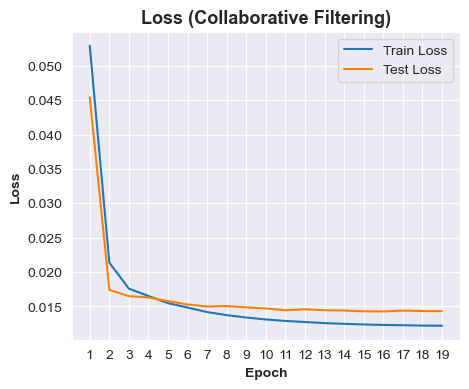

In [40]:
# Visualise the train and test losses
sns.set_style('darkgrid')
plt.figure(figsize=(5, 4))

plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Test Loss')
plt.title('Loss (Collaborative Filtering)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
total_epochs = len(history_1.history['loss'])
plt.xticks(np.arange(0, total_epochs), np.arange(1, total_epochs+1))
plt.legend()

plt.show()

[Back to Contents](#back)

### 5.3 Recommend the Existing Animes with the Highest Predicted Ratings to an Existing User <a id='col_1'></a>

In [41]:
# Define a function to recommend animes with the highest predicted rating
def collaborative_rec_pred_rating_ex_animes(model,
                                            user_id,
                                            anime_ids,
                                            n_rec_animes,
                                            user_encoder,
                                            anime_encoder,
                                            rating_scaler,
                                            anime_info,
                                            rating_info):
    '''
    Find the n highest predicted rating animes for an existing user.
    '''
    # Encode the anime ids and user id
    anime_ids_enc = pd.Series(anime_ids).map(anime_encoder)
    user_id_enc = np.array([user_encoder.get(user_id)] * len(anime_ids_enc))    

    # Predict the ratings for the user
    y_pred = model.predict([user_id_enc, anime_ids_enc], verbose=0)
    rating_pred = rating_scaler.inverse_transform(y_pred)

    # Calculate the mean absolute error of ratings for the animes rated by the user
    animes_rating = rating_info[rating_info['user_id'] == user_id].copy()
    animes_rating['anime_id_enc'] = animes_rating['anime_id'].map(anime_encoder)
    animes_rating['pred_rating'] = rating_pred[animes_rating['anime_id_enc'].values]
    rating_mae = mean_absolute_error(animes_rating['rating'], animes_rating['pred_rating'])

    # Round the pred_rating after MAE calculation
    animes_rating['pred_rating'] = np.round(animes_rating['pred_rating'], 2)
    
    # Show the rating, pred_rating and MAE score
    print(f'For the animes which have been rated by the user (id: {user_id})')
    display(animes_rating[['anime', 'rating', 'pred_rating']].head(5))
    print('**Only the first five results are shown.\n')
    print(f'Mean absolute error of actual ratings and predicted ratings: {rating_mae:.2f}')
    print()

    # Create a dataframe containing the animes which have not been rated  
    df_rec = anime_info[~anime_info['anime_id'].isin(animes_rating['anime_id'])].copy()
    df_rec['anime_id_enc'] = df_rec['anime_id'].map(anime_encoder)
    df_rec['pred_rating'] = np.round(rating_pred[df_rec['anime_id_enc'].values], 2)
    
    df_rec.rename(columns={'anime': 'rec_anime'}, inplace=True)
    df_rec = df_rec.sort_values('pred_rating', ascending=False).reset_index(drop=True)
    
    # Recommend the animes with the highest predicted ratings to the user
    rec_info = ['rec_anime', 'pred_rating', 'genres', 'sypnopsis']
    print(f'For the user (id: {user_id})')
    print(f'Top {n_rec_animes} recommended animes with the highest predicted rating:')
    display(df_rec.head(n_rec_animes)[rec_info])

In [42]:
# Adjust the column width to show the full sypnopsis
pd.set_option('max_colwidth', None)

# Get the required info for recommendation
user_ids = X_user_1.unique()
anime_ids = X_anime_1.unique()
anime_info = df_anime_1[df_anime_1['anime_id'].isin(anime_ids)]

Here, we will recommend animes with the highest predicted rating to a random hardcore anime fan.

In [43]:
# Recommend top 5 animes with the highest predicted ratings for a random user
np.random.seed(1)

rand_idx = np.random.randint(0, len(user_ids))
rand_user_id = user_ids[rand_idx]

collaborative_rec_pred_rating_ex_animes(model=collaborative_rec,
                                        user_id=rand_user_id,
                                        anime_ids=anime_ids,
                                        n_rec_animes=5,
                                        user_encoder=user_encoder,
                                        anime_encoder=anime_encoder,
                                        rating_scaler=sc_target_1,
                                        anime_info=anime_info,
                                        rating_info=df_rating_1)

For the animes which have been rated by the user (id: 205885)


,anime,rating,pred_rating
742481,Saijaku Muhai no Bahamut,6.0,6.19
742482,Code Geass: Boukoku no Akito 5 - Itoshiki Mono-tachi e,7.0,7.25
742483,Sanrio Danshi,5.0,6.01
742484,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka,8.0,7.62
742485,Kaze ga Tsuyoku Fuiteiru,9.0,7.85


**Only the first five results are shown.

Mean absolute error of actual ratings and predicted ratings: 0.50

For the user (id: 205885)
Top 5 recommended animes with the highest predicted rating:


,rec_anime,pred_rating,genres,sypnopsis
0,Koe no Katachi,9.15,"Drama, School, Shounen","s a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye. Now in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends. Koe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
1,Fate/stay night Movie: Heaven's Feel - III. Spring Song,8.88,"Action, Supernatural, Magic, Fantasy",Final of three movies in an adaption of the third route of Fate/stay night.
2,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,8.79,"Supernatural, Drama, Romance, School","Six months ago, Sakuta Azusagawa had a chance encounter with a bunny girl in a library. Ever since then, he’s been blissfully happy with his girlfriend: Mai Sakurajima, that same bunny girl. However, the reappearance of his mysterious first crush, the now-adult Shouko Makinohara, adds a new complication to his relationship with Mai. To make matters worse, he then encounters a middle school Shouko in the hospital, suffering from a grave illness. Mysteriously, his old scars begin throbbing whenever he’s near her. With Shouko’s bizarre situation somehow revolving around him, Sakuta will need to come to terms with his own conflicting feelings, for better or worse. With a girl's life in his hands, just what can he do?"
3,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,8.76,"Slice of Life, Drama, Fantasy","Isabella, the daughter of the noble York family, is enrolled in an all-girls academy to be groomed into a dame worthy of nobility. However, she has given up on her future, seeing the prestigious school as nothing more than a prison from the outside world. Her family notices her struggling in her lessons and decides to hire Violet Evergarden to personally tutor her under the guise of a handmaiden. At first, Isabella treats Violet coldly. Violet seems to be able to do everything perfectly, leading Isabella to assume that she was born with a silver spoon. After some time together, Isabella begins to realize that Violet has had her own struggles and starts to open up to her. Isabella soon reveals that she has lost contact with her beloved younger sister, Taylor Bartlett, whom she yearns to see again. Having experienced the power of words through her past clientele, Violet asks if Isabella wishes to write a letter to Taylor. Will Violet be able to help Isabella convey her feelings to her long-lost sister?"
4,Kimi no Suizou wo Tabetai,8.76,Drama,"The aloof protagonist: a bookworm who is deeply detached from the world he resides in. He has no interest in others and is firmly convinced that nobody has any interest in him either. His story begins when he stumbles across a handwritten book, titled ""Living with Dying."" He soon identifies it as a secret diary belonging to his popular, bubbly classmate Sakura Yamauchi. She then confides in him about the pancreatic disease she is suffering from and that her time left is finite. Only her family knows about her terminal illness; not even her best friends are aware. Despite this revelation, he shows zero sympathy for her plight, but caught in the waves of Sakura's persistent buoyancy, he eventually concedes to accompanying her for her remaining days. As the pair of polar opposites interact, their connection strengthens, 

[Back to Contents](#back)

### 5.4 Recommend an Existing Anime to the Existing Users who Have the Highest Predicted Ratings <a id='col_2'></a>

In [44]:
# Define a function to recommend animes with the highest predicted rating
def collaborative_rec_pred_rating_ex_users(model,
                                           anime_id,
                                           user_ids,
                                           n_rec_users,
                                           user_encoder,
                                           anime_encoder,
                                           rating_scaler,
                                           anime_info,
                                           rating_info):
    '''
    Find the n highest predicted ratings from existing users for an existing anime
    '''
    # Encode the user ids and anime id
    user_ids_enc = pd.Series(user_ids).map(user_encoder)
    anime_id_enc = np.array([anime_encoder.get(anime_id)] * len(user_ids_enc))    

    # Predict the ratings for the user
    y_pred = model.predict([user_ids_enc, anime_id_enc], verbose=0)
    rating_pred = rating_scaler.inverse_transform(y_pred)    

    # Calculate the mean absolute error of ratings from the users who have rated the anime
    users_rating = rating_info[rating_info['anime_id'] == anime_id].copy()
    users_rating['user_id_enc'] = users_rating['user_id'].map(user_encoder)
    users_rating['pred_rating'] = rating_pred[users_rating['user_id_enc'].values]
    rating_mae = mean_absolute_error(users_rating['rating'], users_rating['pred_rating'])    

    # Round the pred_rating after MAE calculation
    users_rating['pred_rating'] = np.round(users_rating['pred_rating'], 2)
    
    # Show the rating, pred_rating and MAE score
    anime_name = anime_info.set_index('anime_id')['anime'].to_dict().get(anime_id)
    print(f'For the users who have rated the anime {anime_name} (id: {anime_id})')
    display(users_rating[['user_id', 'rating', 'pred_rating']].head(5))
    print('**Only the first five results are shown.\n')
    print(f'Mean absolute error of actual ratings and predicted ratings: {rating_mae:.2f}')
    print()
    
    # Create a dataframe containing the users who have not rated the anime    
    df_rec = rating_info[~rating_info['user_id'].isin(users_rating['user_id'])].copy()
    df_rec.drop_duplicates(subset=['user_id'], inplace=True)
    df_rec['user_id_enc'] = df_rec['user_id'].map(user_encoder)
    df_rec['pred_rating'] = np.round(rating_pred[df_rec['user_id_enc'].values], 2)
    
    df_rec.rename(columns={'user_id': 'rec_user_id'}, inplace=True)
    df_rec = df_rec.sort_values('pred_rating', ascending=False).reset_index(drop=True)
    
    # Recommend the anime to the users with the highest predicted ratings
    rec_info = ['rec_user_id', 'pred_rating']
    print(f'For the anime {anime_name} (id: {anime_id})')
    print(f'Recommend the anime to the top {n_rec_users} users with the highest predicted rating:')
    display(df_rec.head(n_rec_users)[rec_info])

Here, we will choose a random anime and recommend it to the top five users with the highest predicted ratings.

In [45]:
# Recommend a random anime to top 5 users with the highest predicted ratings
np.random.seed(1)

rand_idx = np.random.randint(0, len(anime_ids))
rand_anime_id = anime_ids[rand_idx]

collaborative_rec_pred_rating_ex_users(model=collaborative_rec,
                                       anime_id=rand_anime_id,
                                       user_ids=user_ids,
                                       n_rec_users=5,
                                       user_encoder=user_encoder,
                                       anime_encoder=anime_encoder,
                                       rating_scaler=sc_target_1,
                                       anime_info=anime_info,
                                       rating_info=df_rating_1)

For the users who have rated the anime Session High⤴ (id: 36608)


,user_id,rating,pred_rating
1061,781,5.0,5.35
1959,943,6.0,7.33
21433,6548,5.0,4.39
29371,8326,6.0,6.09
38208,10255,6.0,4.95


**Only the first five results are shown.

Mean absolute error of actual ratings and predicted ratings: 0.60

For the anime Session High⤴ (id: 36608)
Recommend the anime to the top 5 users with the highest predicted rating:


,rec_user_id,pred_rating
0,154328,9.62
1,117521,9.61
2,304990,9.61
3,250167,9.60
4,264413,9.56


[Back to Contents](#back)

### 5.5 Recommend the Existing Animes which are Most Similar to the Highest Rated Animes by an Existing User (Item Based Recommendation) <a id='col_3'></a>

In [46]:
# Create a funtion to recommend the animes which are similar to the rated animes by the users
def collaborative_rec_similar_ex_animes(model,
                                        user_id,
                                        n_highest_rated_animes,
                                        n_rec_animes,
                                        anime_encoder,
                                        anime_decoder,
                                        anime_info,
                                        rating_info):
    '''
    Find the n most similar animes based on rated animes.
    '''
    # Extract and normalise the weights from the anime embedding layer
    anime_weights = model.get_layer('anime_embedding').get_weights()[0]
    anime_weights = anime_weights / np.linalg.norm(anime_weights, axis=1).reshape((-1, 1))    

    # Create a dataframe containing the n highest rated animes by the user
    rated_df = rating_info[rating_info['user_id'] == user_id].copy()
    rated_df.sort_values('rating', ascending=False, inplace=True)
    rated_df = rated_df.head(n_highest_rated_animes)

    # Show the highest rated animes
    print(f'For the user (id: {user_id})')
    print(f'The top {n_highest_rated_animes} highest rated animes')
    
    rated_info = ['anime', 'rating', 'genres']
    display(rated_df[rated_info])
    print()
    
    # Calculate the cosine similarity
    rated_ids = rated_df['anime_id']
    rated_ids_enc = rated_ids.map(anime_encoder)
    cos_sim = np.dot(anime_weights, anime_weights.T)
    np.fill_diagonal(cos_sim, -np.inf)    
    cos_sim = cos_sim[rated_ids_enc]
    cos_sim_flatten = cos_sim.flatten()
    
    # Create the dataframe containing the recommended animes and info
    rated_anime_ids = []
    for id in rated_ids:
        rated_anime_ids.extend([id] * len(anime_weights))
    
    rec_anime_ids = []
    for i in range(len(rated_ids)):
        rec_anime_ids.extend(np.vectorize(anime_decoder.get)(np.arange(len(anime_weights))))
    
    df_rec = pd.DataFrame({
        'rated_anime_id': rated_anime_ids,
        'rec_anime_id': rec_anime_ids,
        'cos_similarity': cos_sim_flatten
    })
    
    df_rec = df_rec.merge(rated_df[['anime_id', 'rating', 'anime']], left_on='rated_anime_id', right_on='anime_id', how='left')
    df_rec.rename(columns={'anime': 'rated_anime'}, inplace=True)
    df_rec.drop(columns=['anime_id'], inplace=True)
    
    df_rec = df_rec.merge(anime_info[['anime_id', 'anime', 'genres', 'sypnopsis']], left_on='rec_anime_id', right_on='anime_id', how='left')
    df_rec.rename(columns={'anime': 'rec_anime'}, inplace=True)
    df_rec.drop(columns=['anime_id'], inplace=True)
    
    df_rec = df_rec.sort_values('cos_similarity', ascending=False).reset_index(drop=True)
    
    # Show the recommendation
    rec_info = ['rated_anime', 'rating', 'rec_anime', 'cos_similarity', 'genres', 'sypnopsis']
    print(f'For the user (id: {user_id})')
    print(f'The top {n_rec_animes} most similar animes to the top {n_highest_rated_animes} highest rated animes from the user:')
    display(df_rec[rec_info].head(n_rec_animes))

In [47]:
# Recommend top 5 most similar animes based on rated animes for a random user
np.random.seed(1)

rand_idx = np.random.randint(0, len(user_ids))
rand_user_id = user_ids[rand_idx]

collaborative_rec_similar_ex_animes(model=collaborative_rec,
                                    user_id=rand_user_id,
                                    n_highest_rated_animes=3,
                                    n_rec_animes=5,
                                    anime_encoder=anime_encoder,
                                    anime_decoder=anime_decoder,
                                    anime_info=anime_info,
                                    rating_info=df_rating_1)

For the user (id: 205885)
The top 3 highest rated animes


,anime,rating,genres
742669,Kimi no Na wa.,10.0,"Romance, Supernatural, School, Drama"
742657,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,9.0,"Comedy, Supernatural, Drama, Romance, School"
742777,Fate/stay night: Unlimited Blade Works 2nd Season,9.0,"Action, Fantasy, Magic, Supernatural"



For the user (id: 205885)
The top 5 most similar animes to the top 3 highest rated animes from the user:


,rated_anime,rating,rec_anime,cos_similarity,genres,sypnopsis
0,Kimi no Na wa.,10.0,Koe no Katachi,0.935586,"Drama, School, Shounen","s a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye. Now in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends. Koe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
1,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,9.0,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,0.926067,"Supernatural, Drama, Romance, School","Six months ago, Sakuta Azusagawa had a chance encounter with a bunny girl in a library. Ever since then, he’s been blissfully happy with his girlfriend: Mai Sakurajima, that same bunny girl. However, the reappearance of his mysterious first crush, the now-adult Shouko Makinohara, adds a new complication to his relationship with Mai. To make matters worse, he then encounters a middle school Shouko in the hospital, suffering from a grave illness. Mysteriously, his old scars begin throbbing whenever he’s near her. With Shouko’s bizarre situation somehow revolving around him, Sakuta will need to come to terms with his own conflicting feelings, for better or worse. With a girl's life in his hands, just what can he do?"
2,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,9.0,Kimi no Suizou wo Tabetai,0.867441,Drama,"The aloof protagonist: a bookworm who is deeply detached from the world he resides in. He has no interest in others and is firmly convinced that nobody has any interest in him either. His story begins when he stumbles across a handwritten book, titled ""Living with Dying."" He soon identifies it as a secret diary belonging to his popular, bubbly classmate Sakura Yamauchi. She then confides in him about the pancreatic disease she is suffering from and that her time left is finite. Only her family knows about her terminal illness; not even her best friends are aware. Despite this revelation, he shows zero sympathy for her plight, but caught in the waves of Sakura's persistent buoyancy, he eventually concedes to accompanying her for her remaining days. As the pair of polar opposites interact, their connection strengthens, interweaving through their choices made with each passing day. Her apparent nonchalance and unpredictability disrupts the protagonist's impassive flow of life, gradually opening his heart as he discovers and embraces the true meaning of living."
3,Kimi no Na wa.,10.0,Violet Evergarden,0.847376,"Slice of Life, Drama, Fantasy","The Great War finally came to an end after four long years of conflict; fractured in two, the continent of Telesis slowly began to flourish once again. Caught up in the bloodshed was Violet Evergarden, a young girl raised for the sole purpose of decimating enemy lines. Hospitalized and maimed in a bloody skirmish during the War's final leg, she was left with only words from the person she held dearest, but with no understanding of their meaning. Recovering from her wounds, Violet starts a new life working at CH Postal Services after a falling out with her new intended guardian family. There, she witnesses by pure chance the work of an ""Auto Memory Doll,"" amanuenses that transcribe people's thoughts and feelings into words on paper. Moved by the notion, Violet begins work a

[Back to Contents](#back)

### 5.6 Recommend the Exisitng Highest Rated Animes by the Most Similar Users to an Existing User (User Based Recommendation) <a id= 'col_4'></a>

In [48]:
# Create a funtion to recommend the animes which are similar to the rated animes
def collaborative_rec_similar_ex_users(model,
                                       user_id,
                                       n_similar_users,
                                       n_rec_animes,                                     
                                       user_encoder,
                                       user_decoder,
                                       anime_info,
                                       rating_info):
    '''
    Find the n most highest rated animes from similar users.
    '''
    # Extract and normalise the weights from the anime embedding layer    
    user_weights = model.get_layer('user_embedding').get_weights()[0]
    user_weights = user_weights / np.linalg.norm(user_weights, axis=1).reshape((-1, 1))
    
    user_id_enc = user_encoder.get(user_id)
    
    # Calculate the cosine similarity
    cos_sim = np.dot(user_weights[user_id_enc], user_weights.T)

    # Get the top n similar users
    cos_sim[user_id_enc] = -np.inf 
    sim_user_ids_enc = np.argsort(cos_sim)[-n_similar_users:]
    sim_user_ids = np.vectorize(user_decoder.get)(sim_user_ids_enc)

    # Create the dataframe containing the similar users
    print(f'For the user (id: {user_id})')
    df_sim_user = pd.DataFrame({
        'user_id': sim_user_ids,
        'cos_similarity': cos_sim[sim_user_ids_enc]
    })
    df_sim_user = df_sim_user.sort_values('cos_similarity', ascending=False).reset_index(drop=True)
    
    # Create the dataframe containing the recommended animes and info
    df_rec = rating_info[rating_info['user_id'].isin(sim_user_ids)][['anime_id', 'rating']].copy()
    df_rec = df_rec.groupby('anime_id')['rating'].mean().round(2).reset_index()
    df_rec = df_rec.merge(anime_info[['anime_id', 'anime', 'genres', 'sypnopsis']], on='anime_id', how='left')
    df_rec.rename(columns={'anime': 'rec_anime', 'rating': 'avg_rating' }, inplace=True)
    df_rec = df_rec.sort_values('avg_rating', ascending=False).reset_index(drop=True)
     
    # Show the similar users and recommendation
    print(f'The top {n_similar_users} similar users:')
    display(df_sim_user)
    print()

    rec_info = ['rec_anime', 'avg_rating', 'genres', 'sypnopsis']    
    print(f'For the user (id: {user_id})')
    print(f'The top {n_rec_animes} animes with the highest average ratings from the top {n_similar_users} most similar users:')
    display(df_rec[rec_info].head(n_rec_animes))

In [49]:
# Recommend top 5 highest rated animes from 3 most similar users of a random user
np.random.seed(1)

rand_idx = np.random.randint(0, len(user_ids))
rand_user_id = user_ids[rand_idx]

collaborative_rec_similar_ex_users(model=collaborative_rec,
                                   user_id=rand_user_id,             
                                   n_similar_users=3,
                                   n_rec_animes=5,                                  
                                   user_encoder=user_encoder,
                                   user_decoder=user_decoder,
                                   anime_info=anime_info,
                                   rating_info=df_rating_1)

For the user (id: 205885)
The top 3 similar users:


,user_id,cos_similarity
0,96880,0.794273
1,168666,0.781357
2,331665,0.763201



For the user (id: 205885)
The top 5 animes with the highest average ratings from the top 3 most similar users:


,rec_anime,avg_rating,genres,sypnopsis
0,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,9.0,"Action, Fantasy, Magic, Supernatural","The Fifth Holy Grail War continues, and the ensuing chaos results in higher stakes for all participants. Shirou Emiya continues to participate in the war, aspiring to be a hero of justice who saves everyone. He sets out in search of the truth behind a mysterious dark shadow and its murder spree, determined to defeat it. Meanwhile, Shinji Matou sets his own plans into motion, threatening Shirou through his sister Sakura Matou. Shirou and Rin Toosaka battle Shinji, hoping to relieve Sakura from the abuses of her brother. But the ugly truth of the Matou siblings begins to surface, and many dark secrets are exposed. Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly continues to focus on the remaining Masters and Servants as they fight each other in the hopes of obtaining the Holy Grail. However, as darkness arises within Fuyuki City, even the state of their sacred war could be in danger."
1,Vinland Saga,9.0,"Action, Adventure, Drama, Historical, Seinen","Young Thorfinn grew up listening to the stories of old sailors that had traveled the ocean and reached the place of legend, Vinland. It's said to be warm and fertile, a place where there would be no need for fighting—not at all like the frozen village in Iceland where he was born, and certainly not like his current life as a mercenary. War is his home now. Though his father once told him, ""You have no enemies, nobody does. There is nobody who it's okay to hurt,"" as he grew, Thorfinn knew that nothing was further from the truth. The war between England and the Danes grows worse with each passing year. Death has become commonplace, and the viking mercenaries are loving every moment of it. Allying with either side will cause a massive swing in the balance of power, and the vikings are happy to make names for themselves and take any spoils they earn along the way. Among the chaos, Thorfinn must take his revenge and kill Askeladd, the man who murdered his father. The only paradise for the vikings, it seems, is the era of war and death that rages on."
2,Taisou Zamurai,9.0,Sports,"Year 2002. Japan's gymnastics world was once strong. Former Japanese representative Shoutarou Aragaki (29), who devoted his time to gymnastics, was unable to perform as expected. Even so, after training on a daily basis, his coach Amakusa recommends Shoutarou to retire. However, the fate of the Aragaki family will change significantly due to a certain ""encounter."" (Source: MAL News)"
3,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono Subarashii Geijutsu ni Shukufuku wo!,9.0,"Magic, Adventure, Fantasy, Comedy, Supernatural","Kazuma meets a novice adventurer called Ran who claims to be Kazuma's fan. A quest is proposed to Kazuma and his party in front of Ran, so he accepts the quest to look good in front of his fan; after some convincing, they all go to fight the metal golem. (Source: Wikipedia)"
4,Made in Abyss,9.0,"Sci-Fi, Adventure, Mystery, Drama, Fantasy","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface. Riko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to c

[Back to Contents](#back)

## 6. Content-based Filtering Recommendation System <a id='content'></a>

A content-based recommendation system is a type of recommendation system that suggests items to users based on the characteristics and attributes of items and users, such as text descriptions, tags, genres, or other metadata. Unlike collaborative filtering, content-based filtering focuses on the properties rather than the preferences and behaviours of users.

[Back to Contents](#back)

### 6.1 Data Preparation <a id='con_data'></a>

A user content will be created by calculating the average rating per genre for each user. The average rating can be thought as the user genre preference.

In [50]:
# Create the user content
user_content = df_rating_1[['user_id', 'genres', 'rating']].copy()
user_content['genres'] = user_content['genres'].str.split(', ')

user_content = user_content.explode('genres').pivot_table(
    index = 'user_id',
    columns = 'genres',
    values = 'rating',
    aggfunc = 'mean'
).round(2)

user_content.head()

genres,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
user_id,,,,,,,,,,,,,,,,,,,,,
781,6.38,6.48,5.12,6.12,4.52,5.88,6.34,5.36,6.16,6.12,...,4.25,6.00,5.08,6.25,6.48,6.23,6.38,6.0,5.57,NaN
912,6.56,6.92,9.00,6.83,7.46,7.91,6.88,5.72,6.60,6.79,...,6.27,6.94,6.64,6.85,7.05,6.95,7.75,NaN,6.08,8.0
943,8.19,8.27,7.00,8.23,7.25,8.00,8.32,8.57,8.11,8.16,...,NaN,7.98,7.80,7.92,8.34,8.35,8.50,NaN,7.93,NaN
1177,6.26,6.53,6.00,6.04,7.00,6.13,6.70,5.55,6.20,6.69,...,7.00,6.32,6.70,6.00,6.63,6.28,7.00,NaN,5.00,NaN
1289,7.94,7.92,NaN,7.66,5.50,7.35,7.88,7.48,7.68,7.89,...,NaN,7.36,7.00,7.16,8.20,7.95,8.45,NaN,8.38,NaN


The missing values indicate that the users have not watched any anime with the specific genre. Therefore, the user might not like the genre at all, we can fill these missing values with 0.

In [51]:
# Fill the missing values with 0
user_content.fillna(0, inplace=True)

user_content.head()

genres,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
user_id,,,,,,,,,,,,,,,,,,,,,
781,6.38,6.48,5.12,6.12,4.52,5.88,6.34,5.36,6.16,6.12,...,4.25,6.00,5.08,6.25,6.48,6.23,6.38,6.0,5.57,0.0
912,6.56,6.92,9.00,6.83,7.46,7.91,6.88,5.72,6.60,6.79,...,6.27,6.94,6.64,6.85,7.05,6.95,7.75,0.0,6.08,8.0
943,8.19,8.27,7.00,8.23,7.25,8.00,8.32,8.57,8.11,8.16,...,0.00,7.98,7.80,7.92,8.34,8.35,8.50,0.0,7.93,0.0
1177,6.26,6.53,6.00,6.04,7.00,6.13,6.70,5.55,6.20,6.69,...,7.00,6.32,6.70,6.00,6.63,6.28,7.00,0.0,5.00,0.0
1289,7.94,7.92,0.00,7.66,5.50,7.35,7.88,7.48,7.68,7.89,...,0.00,7.36,7.00,7.16,8.20,7.95,8.45,0.0,8.38,0.0


The anime content will be created with the genres and the sources of animes.

In [52]:
# Create the anime content
drop_anime_features = ['anime', 'score', 'genres', 'aired', 'producers',
                       'licensors', 'studios', 'sypnopsis', 'premiered']
anime_content = df_anime_1.drop(columns=drop_anime_features)
anime_content = pd.get_dummies(anime_content, dtype=int)
anime_content = pd.concat([anime_content, df_anime_1['genres'].str.get_dummies(', ')], axis=1)

anime_content.head()

,anime_id,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,9260,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,9488,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,10937,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,15199,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Preparing features and target for training the recommendation system
X_user_2 = df_rating_1[['user_id']].merge(user_content, on='user_id', how='left')
X_user_2.drop(columns='user_id', inplace=True)
X_anime_2 = df_rating_1[['anime_id']].merge(anime_content, on='anime_id', how='left')
X_anime_2.drop(columns='anime_id', inplace=True)
y_2 = df_rating_1['rating']

# Scale the targets to a range between 0 and 1
# So that we can get a score of 0 to 1 with sigmoid activation function
sc_target_2 = MinMaxScaler()
y_2_scale = pd.Series(sc_target_2.fit_transform(y_2.values.reshape(-1, 1))[:,0], index=y_2.index)

# Split the datasets into train:test = 99:1 since we have a lot of data
X_user_2_train, X_user_2_test, X_anime_2_train, X_anime_2_test, y_2_train, y_2_test = train_test_split(
    X_user_2, X_anime_2, y_2_scale, test_size=0.01, random_state=42
)

# Scale the features
sc_user = StandardScaler()
X_user_2_train = sc_user.fit_transform(X_user_2_train)
X_user_2_test = sc_user.transform(X_user_2_test)

sc_anime = StandardScaler()
X_anime_2_train = sc_anime.fit_transform(X_anime_2_train)
X_anime_2_test = sc_anime.transform(X_anime_2_test)

# Get the input dimensions
n_user_features = X_user_2.shape[1]
n_anime_features = X_anime_2.shape[1]

In [54]:
# Print some info
print(f'Number of user features: {n_user_features}')
print(f'Number of animes features: {n_anime_features}')
print()

print(f'Shape of X_user_2_train: {X_user_2_train.shape}')
print(f'Shape of X_anime_2_train: {X_anime_2_train.shape}')
print(f'Shape of y_2_train: {y_2_train.shape}')
print(f'Shape of X_user_2_test: {X_user_2_test.shape}')
print(f'Shape of X_anime_2_test: {X_anime_2_test.shape}')
print(f'Shape of y_2_test: {y_2_test.shape}')

Number of user features: 42
Number of animes features: 58

Shape of X_user_2_train: (1243463, 42)
Shape of X_anime_2_train: (1243463, 58)
Shape of y_2_train: (1243463,)
Shape of X_user_2_test: (12561, 42)
Shape of X_anime_2_test: (12561, 58)
Shape of y_2_test: (12561,)


[Back to Contents](#back)

### 6.2 Modeling <a id='con_model'></a>

In [55]:
# Saving paths
checkpoint_path_2 = os.path.join(model_folder, 'content_rec_weights.h5')
model_path_2 = os.path.join(model_folder, 'content_rec_model.keras')

In [56]:
# Define the model
def content_based_filtering_recommender(num_features, dropout_rate):
    # Extract high level features from user features
    user_NN = Sequential([
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_features, activation='linear')
    ], name='user_NN')

    # Extract high level features from anime features
    anime_NN = Sequential([
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_features, activation='linear')
    ], name='anime_NN')

    # Create the user input and anime input
    user_input = Input(shape=[n_user_features], name='user_input')
    user_vector = user_NN(user_input)
    user_vector = tf.linalg.l2_normalize(user_vector, axis=1)

    anime_input = Input(shape=[n_anime_features], name='anime_input')
    anime_vector = anime_NN(anime_input)
    anime_vector = tf.linalg.l2_normalize(anime_vector, axis=1)

    # Calculate the dot products of the two vectors
    x = Dot(axes=1, normalize=True, name='dot_product')([user_vector, anime_vector])
    x = Dense(1, activation='sigmoid')(x)
    
    # Create and compile the model
    model = Model(inputs=[user_input, anime_input], outputs=x)
    model.compile(loss='mse', metrics=['mae'], optimizer=Adam())

    return model

In [57]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model instance
content_rec = content_based_filtering_recommender(num_features=64,
                                                  dropout_rate=0.0)

content_rec.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 42)]                 0         []                            
                                                                                                  
 anime_input (InputLayer)    [(None, 58)]                 0         []                            
                                                                                                  
 user_NN (Sequential)        (None, 64)                   52160     ['user_input[0][0]']          
                                                                                                  
 anime_NN (Sequential)       (None, 64)                   56256     ['anime_input[0][0]']         
                                                                                            

In [58]:
# Define callback
# Learning rate
def lr_schedule_2(epoch, learning_rate):
    init_lr = 1e-5
    min_lr = 1e-5
    max_lr = 1e-2

    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = 0.8
    
    if epoch < rampup_epochs:
        return (max_lr - init_lr) / (rampup_epochs) * epoch + init_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_scheduler_2 = LearningRateScheduler(lr_schedule_2)

# Model checkpoints
model_checkpoints_2 = ModelCheckpoint(filepath=checkpoint_path_2,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True)

# Early stopping
early_stopping_2 = EarlyStopping(patience=4,
                                 monitor='val_loss',
                                 mode='min',
                                 restore_best_weights=True)

callbacks = [lr_scheduler_2, model_checkpoints_2, early_stopping_2]

In [59]:
# Train the model
history_2 = content_rec.fit(x=[X_user_2_train, X_anime_2_train],
                            y=y_2_train,
                            epochs=30,
                            validation_data=([X_user_2_test, X_anime_2_test], y_2_test),
                            callbacks=callbacks)

# Load the weights of best model
content_rec.load_weights(checkpoint_path_2)

# Save the best model
content_rec.save(model_path_2)

Epoch 1/30
38859/38859 [==============================] - 76s 2ms/step - loss: 0.0238 - mae: 0.1181 - val_loss: 0.0215 - val_mae: 0.1114 - lr: 1.0000e-05
Epoch 2/30
38859/38859 [==============================] - 75s 2ms/step - loss: 0.0191 - mae: 0.1040 - val_loss: 0.0180 - val_mae: 0.1013 - lr: 0.0020
Epoch 3/30
38859/38859 [==============================] - 75s 2ms/step - loss: 0.0181 - mae: 0.1006 - val_loss: 0.0180 - val_mae: 0.1006 - lr: 0.0040
Epoch 4/30
38859/38859 [==============================] - 76s 2ms/step - loss: 0.0176 - mae: 0.0992 - val_loss: 0.0178 - val_mae: 0.0992 - lr: 0.0060
Epoch 5/30
38859/38859 [==============================] - 78s 2ms/step - loss: 0.0173 - mae: 0.0983 - val_loss: 0.0175 - val_mae: 0.0987 - lr: 0.0080
Epoch 6/30
38859/38859 [==============================] - 78s 2ms/step - loss: 0.0170 - mae: 0.0975 - val_loss: 0.0173 - val_mae: 0.0985 - lr: 0.0100
Epoch 7/30
38859/38859 [==============================] - 77s 2ms/step - loss: 0.0166 - mae: 0.0

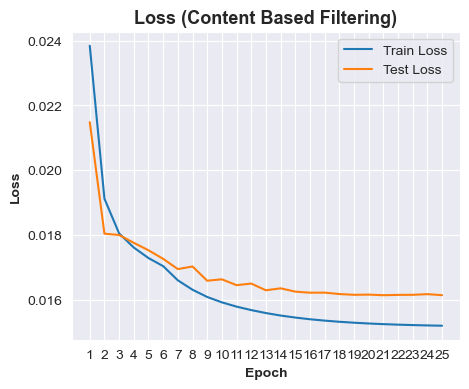

In [60]:
# Visualise the train and test losses
sns.set_style('darkgrid')
plt.figure(figsize=(5, 4))

plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Test Loss')
plt.title('Loss (Content Based Filtering)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
total_epochs = len(history_2.history['loss'])
plt.xticks(np.arange(0, total_epochs), np.arange(1, total_epochs+1))
plt.legend()

plt.show()

[Back to Contents](#back)

### 6.3 New Anime and New User <a id='new'></a>

We will get a new anime and a new user to demonstrate the recommender.

For the new anime, we will use a popular anime in 2023 - Sousou no Frieren.

For the new user, we will create a new user with some custom ratings for genres.

**New Anime - `Sousou no Frieren`**

In [61]:
# Have a look at the required anime content
X_anime_2.columns

Index(['source_4-koma manga', 'source_Book', 'source_Card game',
       'source_Digital manga', 'source_Game', 'source_Light novel',
       'source_Manga', 'source_Music', 'source_Novel', 'source_Original',
       'source_Other', 'source_Picture book', 'source_Radio', 'source_Unknown',
       'source_Visual novel', 'source_Web manga', 'Action', 'Adventure',
       'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy',
       'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi'],
      dtype='object')

In [62]:
# Create the content for the anime Sousou no Frieren
# source_Manga=1, Adventure=1, Drama=1, Fantasy=1, Shounen=1
new_anime_info = pd.DataFrame({
    'source_Manga': 1,
    'Adventure': 1,
    'Drama': 1,
    'Fantasy': 1,
    'Shounen': 1
}, index=[0])

new_anime_info = pd.concat([pd.DataFrame(columns=X_anime_2.columns), new_anime_info])
new_anime_info.fillna(0, inplace=True)

new_anime_info['anime_id'] = int(df_anime['anime_id'].max()) + 1
new_anime_info['anime'] = 'Sousou no Frieren'

new_anime_info

,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,...,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,anime_id,anime
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,48457,Sousou no Frieren


**New User**

In [63]:
# Have a look at the required user content
X_user_2.columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei',
       'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi'],
      dtype='object')

In [64]:
# Create the content for the new user
# Feel free to experiment different values
new_user_info = pd.DataFrame({
    'Action': 9.0,
    'Adventure': 7.0,
    'Cars': 6.5,
    'Comedy': 0.0,
    'Dementia': 0.0,
    'Demons': 9.2,
    'Drama': 0.0,
    'Ecchi': 0.0,
    'Fantasy': 9.5,
    'Game': 9.3,
    'Harem': 0.0,
    'Historical': 0.0,
    'Horror': 0.0,
    'Josei': 0.0,
    'Kids': 0.0,
    'Magic': 8.8,
    'Martial Arts': 7.2,
    'Mecha': 0.0,
    'Military': 0.0,
    'Music': 0.0,
    'Mystery': 7.7,
    'Parody': 4.2,
    'Police': 0.0,
    'Psychological': 8.1,
    'Romance': 0.0,
    'Samurai': 9.1,
    'School': 8.3,
    'Sci-Fi': 7.4,
    'Seinen': 0.0,
    'Shoujo': 0.0,
    'Shoujo Ai': 0.0,
    'Shounen': 5.3,
    'Shounen Ai': 7.1,
    'Slice of Life': 0.0,
    'Space': 0.0,
    'Sports': 7.4,
    'Super Power': 9.1,
    'Supernatural': 8.2,
    'Thriller': 0.0,
    'Unknown': 0.0,
    'Vampire': 9.4,
    'Yaoi': 0.0
}, index=[0])

new_user_info['user_id'] = int(df_rating['user_id'].max()) + 1

new_user_info

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,user_id
0,9.0,7.0,6.5,0.0,0.0,9.2,0.0,0.0,9.5,9.3,...,0.0,0.0,7.4,9.1,8.2,0.0,0.0,9.4,0.0,353404


[Back to Contents](#back)

### 6.4 Existing Anime and User Contents <a id='existing'></a>

Here, we will precalculated some necessary anime and user inputs for the recommendation.

In [65]:
# Existing anime contents
drop_anime_features = ['anime', 'score', 'genres', 'aired', 
                      'producers', 'licensors', 'studios', 'sypnopsis', 'premiered']
ex_anime_content = anime_info.drop(columns=drop_anime_features)
ex_anime_content = pd.get_dummies(ex_anime_content, dtype=int)
ex_anime_content = pd.concat([ex_anime_content, anime_info['genres'].str.get_dummies(', ')], axis=1)

ex_anime_content.sample()

,anime_id,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
1031,33728,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Existing user contents
ex_user_content = df_rating_1[['user_id', 'genres', 'rating']].copy()
ex_user_content['genres'] = ex_user_content['genres'].str.split(', ')

ex_user_content = ex_user_content.explode('genres').pivot_table(
    index = 'user_id',
    columns = 'genres',
    values = 'rating',
    aggfunc = 'mean'
).round(2)

ex_user_content.fillna(0, inplace=True)
ex_user_content = ex_user_content.reset_index().rename_axis(columns={'genres': ''})

ex_user_content.sample()

,user_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
1348,263807,8.02,8.2,0.0,8.17,6.0,7.87,8.43,7.88,8.04,...,0.0,8.29,8.22,8.1,8.11,8.23,8.5,0.0,8.11,0.0


[Back to Contents](#back)

### 6.5 Recommend the Existing Animes with the Highest Predicted Rating to a New User <a id='con_1'></a>

In [67]:
# Define a function to recommend animes with the highest predicted rating
def content_rec_pred_rating_new_user(model,
                                     new_user_info,
                                     ex_anime_content,
                                     n_rec_animes,
                                     user_scaler,
                                     anime_scaler,
                                     rating_scaler,
                                     anime_info):
    '''
    Find the n highest predicted rating animes for the new user.
    '''
    # Create the new user and exsiting anime contents
    user = user_scaler.transform(new_user_info.drop(columns=['user_id']))
    user = np.array([user.flatten()] * len(ex_anime_content))

    animes = anime_scaler.transform(ex_anime_content.drop(columns='anime_id'))
    
    # Predict the ratings for the user
    y_pred = model.predict([user, animes], verbose=0)
    rating_pred = rating_scaler.inverse_transform(y_pred)

    # Create a dataframe containing the anime info with predicted ratings for the new user
    df_rec = anime_info[['anime_id', 'anime', 'genres', 'sypnopsis']].copy()
    df_rec['pred_rating'] = np.round(rating_pred, 2)

    df_rec.rename(columns={'anime': 'rec_anime'}, inplace=True)
    df_rec = df_rec.sort_values('pred_rating', ascending=False).reset_index(drop=True)
    
    # Recommend the animes with the highest predicted ratings to the new user
    rec_info = ['rec_anime', 'pred_rating', 'genres', 'sypnopsis']
    new_user_id = new_user_info['user_id'][0]
    print(f'For the new user (id: {new_user_id})')
    print(f'Top {n_rec_animes} recommended animes with the highest predicted rating:')
    display(df_rec.head(n_rec_animes)[rec_info])

In [68]:
# Recommend top 5 animes with the highest predicted rating to the new user
content_rec_pred_rating_new_user(model=content_rec,
                                 n_rec_animes=5,
                                 new_user_info=new_user_info,
                                 ex_anime_content=ex_anime_content,
                                 user_scaler=sc_user,
                                 anime_scaler=sc_anime,
                                 rating_scaler=sc_target_2,                               
                                 anime_info=anime_info)

For the new user (id: 353404)
Top 5 recommended animes with the highest predicted rating:


,rec_anime,pred_rating,genres,sypnopsis
0,Code Geass: Fukkatsu no Lelouch,9.14,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","Since the demise of the man believed to be Britannia's most wicked emperor one year ago, the world has enjoyed an unprecedented peace under the guidance of the United Federation of Nations. However, this fragile calm is shattered when armed militants successfully kidnap former princess Nunnally vi Britannia and Suzaku Kururugi, the chief advisor of the Black Knights, sparking an international crisis. The powerful and untrustworthy Kingdom of Zilkhstan is accused of orchestrating their capture. To investigate, world authorities send Kallen Stadtfeld and her associates on a covert operation into the country. There, they encounter the immortal witch C.C., who is on a mission to complete the resurrection of the man responsible for the greatest revolution in history—a legend who will rise up, take command, and save the world from peril once again."
1,Code Geass: Hangyaku no Lelouch III - Oudou,9.09,"Action, Mecha, Military, School, Sci-Fi, Super Power","louch Lamperouge's dreams of destroying the Holy Britannian Empire are slowly crumbling. His sister, Nunnally, has been kidnapped by Schneizel el Britannia, and Suzaku Kururugi is ignoring his desperate pleas for assistance. The Black Knights are slowly losing faith in Lelouch as their leader, and the United Federation of Nations has declared global war on Britannia. Having suffered numerous betrayals, a significant loss of power, and an ever-growing resentment towards Emperor Charles zi Britannia, the crippled Lelouch makes a final decision: if he can't destroy the Empire from the outside, he will take it for himself from within."
2,Code Geass: Hangyaku no Lelouch II - Handou,9.09,"Action, Mecha, Military, School, Sci-Fi, Super Power","Having achieved miraculous victories in a series of battles against the Britannian Army, Lelouch Lamperouge has brought the Black Knights, his paramilitary organization, to a more powerful state than ever before. Nothing seems impossible for him when he utilizes his military strength, intellect, and Geass power of absolute obedience. However, obstacles in the face of the uprising never cease, putting Lelouch in a difficult predicament. Most worryingly, Suzaku Kururugi's combat prowess and the appearance of a mysterious child named V.V. threaten to put an end to Lelouch's great rebellion."
3,Code Geass: Hangyaku no Lelouch I - Koudou,9.09,"Action, Military, Sci-Fi, Super Power, Mecha, School","The Holy Britannian Empire is a powerful nation that uses its military strength to expand its rule, and the small island nation of Japan is yet another victim. During a worldwide conflict in 2010 known as the Second Pacific War, the once-proud country was reduced to rubble and mockingly renamed to Area 11. However, one student plans to free Japan from Britannia's control through an extraordinary rebellion. His name is Lelouch Lamperouge, and he is fueled with hatred for the Empire, plotting to wipe its accursed name off the face of the planet. Lelouch's malicious plans are unexpectedly accelerated upon meeting the mysterious woman C.C., who grants him a supernatural ability known as ""Geass"" that makes anyone Lelouch commands unable to defy his will. Now armed with a devastating power, Lelouch assumes the persona of Zero, a revolutionary figure who carries the hopes and dreams of the oppressed around the world. He vows to restore the glorious nation of Japan and deliver divine retribution to Britannia."
4,Dragon Ball Super Movie: Broly,8.83,"Action, Adventure, Super Power, Martial Arts, Fantasy, Shounen","Forty-one years ago on Planet Vegeta, home of the infamous Saiyan warrior race, King Vegeta noticed a baby named Broly whose latent power exceeded that of his own son. Believing that Broly's power would one day surpass that of his child, Vegeta, the king sends Broly to the desolate planet Vampa. Broly's father Paragus follows af

[Back to Contents](#back)

### 6.6 Recommend a New Anime to the Existing Users who Have the Highest Precticted Ratings <a id='con_2'></a>

In [69]:
# Define a function to recommend animes with the highest predicted rating
def content_rec_pred_rating_new_anime(model,
                                      n_rec_users,
                                      new_anime_info,
                                      ex_user_content,
                                      user_scaler,
                                      anime_scaler,
                                      rating_scaler):
    '''
    Find the n highest user predicted ratings for a new anime.
    '''
    # Create the new anime and existing user content
    anime = anime_scaler.transform(new_anime_info.drop(columns=['anime_id', 'anime']))
    anime = np.array([anime.flatten()] * len(ex_user_content))

    users = user_scaler.transform(ex_user_content.drop(columns=['user_id']))
    
    # Predict the user ratings for the new anime
    y_pred = model.predict([users, anime], verbose=0)
    rating_pred = rating_scaler.inverse_transform(y_pred)

    # Create a dataframe containing the user predicted ratings for the new anime
    df_rec = pd.DataFrame({
        'user_id': ex_user_content['user_id'],
        'pred_rating': np.round(rating_pred.flatten(), 2)
    })

    df_rec.rename(columns={'user_id': 'rec_user_id'}, inplace=True)
    df_rec = df_rec.sort_values('pred_rating', ascending=False).reset_index(drop=True)
    
    # Recommend the animes with the highest predicted ratings to the new user
    new_anime_name = new_anime_info['anime'][0]
    new_anime_id = new_anime_info['anime_id'][0]
    print(f'For the new anime {new_anime_name} (id: {new_anime_id})')
    print(f'Recommend the anime to the top {n_rec_users} users with the highest predicted rating:')
    display(df_rec.head(n_rec_users))

In [70]:
# Recommend the new anime to the top 5 users with the highest predicted ratings
content_rec_pred_rating_new_anime(model=content_rec,
                                  n_rec_users=5,
                                  new_anime_info=new_anime_info,
                                  ex_user_content=ex_user_content,
                                  user_scaler=sc_user,
                                  anime_scaler=sc_anime,
                                  rating_scaler=sc_target_2)

For the new anime Sousou no Frieren (id: 48457)
Recommend the anime to the top 5 users with the highest predicted rating:


,rec_user_id,pred_rating
0,304990,9.99
1,154328,9.98
2,195259,9.98
3,307749,9.98
4,157363,9.98


[Back to Contents](#back)

### 6.7 Recommend a New Anime to the Existing Users who Have the Highest Ratings on Similar Animes (Item Based Recommendation) <a id='con_3'></a>

In [71]:
# Create the model to calculate the anime high level features
anime_input = Input(shape=[n_anime_features])
anime_vector = content_rec.get_layer('anime_NN')(anime_input)
anime_vector = tf.linalg.l2_normalize(anime_vector, axis=1)
anime_model = Model(inputs=anime_input, outputs=anime_vector)
anime_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 58)]              0         
                                                                 
 anime_NN (Sequential)       (None, 64)                56256     
                                                                 
 tf.math.l2_normalize_2 (TF  (None, 64)                0         
 OpLambda)                                                       
                                                                 
Total params: 56256 (219.75 KB)
Trainable params: 56256 (219.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# Create a funtion to recommend the new anime to the existing users who rated similar animes
def content_rec_similar_new_anime(model,
                                  n_similar_animes,
                                  n_rec_users,
                                  anime_scaler,
                                  new_anime_info,
                                  ex_anime_content,
                                  rating_info,
                                  anime_info):
    '''
    Find the n users with the highest ratings for the similar animes.
    '''
    # Input for the model
    animes_info = pd.concat([
        new_anime_info.drop(columns=['anime']),
        ex_anime_content
    ]).reset_index(drop=True)    
    animes = anime_scaler.transform(animes_info.drop(columns=['anime_id']))

    # Calculate the features
    anime_v = model.predict(animes, verbose=0)
    anime_v = anime_v / np.linalg.norm(anime_v, axis=1).reshape((-1, 1))

    # Calculate the cosine similarity and find the top n similar animes
    cos_sim = np.dot(anime_v[0], anime_v.T)
    cos_sim[0] = -np.inf
    rec_sim_idx = np.argsort(cos_sim)[-n_similar_animes:]

    # Create a dataframe containing the top n similar animes
    idx_to_anime_id = animes_info['anime_id'].to_dict()
    df_sim_animes = pd.DataFrame(index=rec_sim_idx)
    df_sim_animes['anime_id'] = df_sim_animes.index.map(idx_to_anime_id)
    df_sim_animes = df_sim_animes.merge(anime_info, on='anime_id', how='left')
    df_sim_animes['cos_similarity'] = np.round(cos_sim[rec_sim_idx], 4)
    df_sim_animes = df_sim_animes.sort_values('cos_similarity', ascending=False).reset_index(drop=True)
    
    # Show the top n similar animes
    new_anime_id = new_anime_info['anime_id'][0]
    new_anime_name = new_anime_info['anime'][0]
    new_anime_genres = new_anime_info
    new_anime_content = new_anime_info.columns[new_anime_info.eq(1).any()].tolist()
    
    sim_info = ['anime_id', 'anime', 'cos_similarity', 'genres', 'source']
    print(f'For the new anime {new_anime_name} (id: {new_anime_id})')
    print(new_anime_content)
    print(f'The top {n_similar_animes} most similar animes')
    display(df_sim_animes[sim_info].head(n_similar_animes))
    print()
    
    # Show the top n users with the highest ratings for the similar animes
    df_rec = rating_info[rating_info['anime_id'].isin(df_sim_animes['anime_id'])].copy()    
    df_rec = df_rec.merge(df_sim_animes[['anime_id', 'source']], on='anime_id', how='left')
    df_rec = df_rec.sort_values('rating', ascending=False).reset_index(drop=True)
    df_rec.drop_duplicates(subset=['user_id'], inplace=True)
    df_rec.rename(columns={'anime': 'rated_anime', 'user_id': 'rec_user_id'}, inplace=True)    
    
    rec_info = ['rec_user_id', 'rated_anime', 'rating', 'genres', 'source']
    print(f'For the new anime {new_anime_name} (id: {new_anime_id})')
    print(new_anime_content)
    print(f'The top {n_rec_users} users with the highest rated animes similar to the top {n_similar_animes} similar animes')
    display(df_rec[rec_info].head(n_rec_users))

In [73]:
# Recommend the new anime to the top 5 users who have the highest ratings for the 3 most similar animes
content_rec_similar_new_anime(model=anime_model,
                              n_similar_animes=3,
                              n_rec_users=5,
                              anime_scaler=sc_anime,
                              new_anime_info=new_anime_info,
                              ex_anime_content=ex_anime_content,
                              rating_info=df_rating_1,
                              anime_info=anime_info)

For the new anime Sousou no Frieren (id: 48457)
['source_Manga', 'Adventure', 'Drama', 'Fantasy', 'Shounen']
The top 3 most similar animes


,anime_id,anime,cos_similarity,genres,source
0,40230,Housekishou Richard-shi no Nazo Kantei,0.9812,"Drama, Mystery, Slice of Life",Novel
1,37623,Chiisana Eiyuu: Kani to Tamago to Toumei Ningen,0.9756,"Action, Adventure, Drama, Fantasy",Original
2,39531,Kuutei Dragons,0.9749,"Adventure, Fantasy, Seinen",Manga



For the new anime Sousou no Frieren (id: 48457)
['source_Manga', 'Adventure', 'Drama', 'Fantasy', 'Shounen']
The top 5 users with the highest rated animes similar to the top 3 similar animes


,rec_user_id,rated_anime,rating,genres,source
0,51954,Chiisana Eiyuu: Kani to Tamago to Toumei Ningen,10.0,"Action, Adventure, Drama, Fantasy",Original
1,263526,Housekishou Richard-shi no Nazo Kantei,10.0,"Drama, Mystery, Slice of Life",Novel
2,298783,Chiisana Eiyuu: Kani to Tamago to Toumei Ningen,10.0,"Action, Adventure, Drama, Fantasy",Original
3,43578,Chiisana Eiyuu: Kani to Tamago to Toumei Ningen,10.0,"Action, Adventure, Drama, Fantasy",Original
5,311795,Kuutei Dragons,10.0,"Adventure, Fantasy, Seinen",Manga


[Back to Contents](#back)

### 6.8 Recommend the Exisitng Highest Rated Animes by the Most Similar Users to a New User (User Based Recommendation) <a id='con_4'></a>

In [74]:
# Create the model to calculate the user high level features
user_input = Input(shape=[n_user_features])
user_vector = content_rec.get_layer('user_NN')(user_input)
user_vector = tf.linalg.l2_normalize(user_vector, axis=1)
user_model = Model(inputs=user_input, outputs=user_vector)
user_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 42)]              0         
                                                                 
 user_NN (Sequential)        (None, 64)                52160     
                                                                 
 tf.math.l2_normalize_3 (TF  (None, 64)                0         
 OpLambda)                                                       
                                                                 
Total params: 52160 (203.75 KB)
Trainable params: 52160 (203.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
# Create a funtion to recommend the new user with the higest rated animes from the similar users
def content_rec_similar_new_user(model,
                                 n_similar_users,
                                 n_rec_animes,
                                 user_scaler,
                                 new_user_info,
                                 ex_user_content,
                                 rating_info,
                                 anime_info):
    '''
    Find the n highest rated animes from the similar users.
    '''
    # Input for the model
    users_info = pd.concat([
        new_user_info,
        ex_user_content
    ]).reset_index(drop=True)    
    users = user_scaler.transform(users_info.drop(columns=['user_id']))

    # Calculate the features
    user_v = model.predict(users, verbose=0)
    user_v = user_v / np.linalg.norm(user_v, axis=1).reshape((-1, 1))

    # Calculate the cosine similarity and find the top n similar users
    cos_sim = np.dot(user_v[0], user_v.T)
    cos_sim[0] = -np.inf
    rec_sim_idx = np.argsort(cos_sim)[-n_similar_users:]

    # Create a dataframe containing the top n similar users
    idx_to_user_id = users_info['user_id'].to_dict()
    df_sim_users = pd.DataFrame(index=rec_sim_idx)
    df_sim_users['user_id'] = df_sim_users.index.map(idx_to_user_id)
    df_sim_users['cos_similarity'] = np.round(cos_sim[rec_sim_idx], 4)
    df_sim_users = df_sim_users.sort_values('cos_similarity', ascending=False).reset_index(drop=True)
    
    # Show the top n similar users
    new_user_id = new_user_info['user_id'][0]
    
    sim_info = ['user_id', 'cos_similarity']
    print(f'For the new user (id: {new_user_id})')
    print(f'The top {n_similar_users} most similar users')
    display(df_sim_users[sim_info].head(n_similar_users))
    print()
    
    # Show the top n animes with the highest ratings from the similar users
    df_rec = rating_info[rating_info['user_id'].isin(df_sim_users['user_id'])][['anime_id', 'rating']].copy()
    df_rec = df_rec.groupby('anime_id')['rating'].mean().round(2).reset_index()
    df_rec = df_rec.merge(anime_info[['anime_id', 'anime', 'genres', 'sypnopsis']], on='anime_id', how='left')
    df_rec.rename(columns={'anime': 'rec_anime', 'rating': 'avg_rating'}, inplace=True)
    df_rec = df_rec.sort_values('avg_rating', ascending=False).reset_index(drop=True)   
    
    rec_info = ['rec_anime', 'avg_rating', 'genres', 'sypnopsis']
    print(f'For the new user (id: {new_user_id})')
    print(f'The top {n_rec_animes} animes with the highest average ratings from the top {n_similar_users} most similar users')
    display(df_rec[rec_info].head(n_rec_animes))

In [76]:
# Recommend the user with the top 5 highest rated animes from the top 3 most similar users
content_rec_similar_new_user(model=user_model,
                             n_similar_users=3,
                             n_rec_animes=5,
                             user_scaler=sc_user,
                             new_user_info=new_user_info,
                             ex_user_content=ex_user_content,
                             rating_info=df_rating_1,
                             anime_info=anime_info)

For the new user (id: 353404)
The top 3 most similar users


,user_id,cos_similarity
0,121938,0.6831
1,315411,0.6825
2,281985,0.6632



For the new user (id: 353404)
The top 5 animes with the highest average ratings from the top 3 most similar users


,rec_anime,avg_rating,genres,sypnopsis
0,ReLIFE: Kanketsu-hen,10.0,"Romance, School, Slice of Life","fter reliving the life of a high school student through the ReLIFE experiment, 27-year-old Arata Kaizaki cannot believe how quickly it has changed him. He has begun to see the world through a different perspective that he had completely forgotten as an adult. He has made friends and formed deep relationships with each one of them. However his support, Ryou Yoake, reminds him that the experiment is all an illusion; after his experiment ends, he will be forgotten by all of them. The experiment of another ReLIFE subject is also coming to an end. After spending two years with ReLIFE, Chizuru Hishiro has developed into a more open, more thoughtful person than she could have ever imagined. She has met people who have changed her life, her perspective, and ultimately her. However, now that their ReLIFE is coming to an end, will they be able to let go of the memories they have made?"
1,Saiki Kusuo no Ψ-nan: Kanketsu-hen,10.0,"Comedy, School, Shounen, Slice of Life, Supernatural",daptation of the final chapters of the Saiki Kusuo no Ψ-nan manga.
2,Boku no Hero Academia the Movie: Futari no Hero Specials,10.0,"Action, Super Power, Shounen",Short specials included with the Blu-ray/DVD release of Boku no Hero Academia the Movie: Futari no Hero .
3,Dr. Stone,10.0,"Sci-Fi, Adventure, Shounen","fter five years of harboring unspoken feelings, high-schooler Taiju Ooki is finally ready to confess his love to Yuzuriha Ogawa. Just when Taiju begins his confession however, a blinding green light strikes the Earth and petrifies mankind around the world—turning every single human into stone. Several millennia later, Taiju awakens to find the modern world completely nonexistent, as nature has flourished in the years humanity stood still. Among a stone world of statues, Taiju encounters one other living human: his science-loving friend Senkuu, who has been active for a few months. Taiju learns that Senkuu has developed a grand scheme—to launch the complete revival of civilization with science. Taiju's brawn and Senkuu's brains combine to forge a formidable partnership, and they soon uncover a method to revive those petrified. However, Senkuu's master plan is threatened when his ideologies are challenged by those who awaken. All the while, the reason for mankind's petrification remains unknown."
4,Enen no Shouboutai,10.0,"Action, Supernatural, Shounen","Spontaneous Human Combustion: a chaotic phenomenon that has plagued humanity for years, randomly transforming ordinary people into flaming, violent creatures known as Infernals. While Infernals make up the first-generation accounts of Human Combustion, the second and third generations became known as pyrokinetics—people gifted with the ability to manipulate and control their flames while remaining human. To combat the Infernal threat and discover the cause, the Tokyo Armed Forces, Fire Defense Agency, and Holy Church of Sol produced their answer: the Special Fire Force. Young and eager third-generation pyrokinetic Shinra Kusakabe, nicknamed Devil's Footprints for his explosive ability to ignite his feet at will, becomes a member of the lively Special Fire Force Company 8. Upholding the brigade's duty to extinguish the blazing Infernals and lay their souls to rest, Shinra is determined to become a hero who will save the lives of those threatened by the flame terror. However, this is not the hero's game Shinra imagined. The Fire Force is a fractured mess of feuding brigades, abnormal Infernal sightings are increasing all over Tokyo, and a shadowy group is claiming to have answers to the strange fire that caused the death of Shinra's family 12 years ago. Faced with many obstacles within and outside the Fire Force, Shinra fights to uncover the truth behind the burning mysteries that have kept him in the dark."


[Back to Contents](#back)

## 7. References <a id='ref'></a>

1. [Recommendation System (CF) | Anime](https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime) by CHAITANYA (Kaggle)
2. C3_W2_RecSysNN_Assignment from [Machine Learning Specialization](https://www.coursera.org/specializations/machine-learning-introduction) course by Deep Learning.AI and Stanford University (Coursera)

[Back to Contents](#back)